- check unique - some columns with only 1 value
- check collinearity - can drop 200 columns from this
- try models with feature_importances: decision tree and MARS
    - stick with predictors with highest importances
- PCA after removing collinear predictors?
- tune models: RF, MARS, logreg (maybe), AdaBoost, XGBoost
- Ensemble
- Colab for RF GridSearch

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
train = pd.read_csv('train.csv')
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [52]:
train.shape

(5380, 767)

Removing NAs almost halved the dataset. Two options:
- continue as usual. performance will probably suffer.
- imputation:
    - mean
    - lin reg prediction imputation?
    - k-NN imputation

In [62]:
# check how many observations have missing values
train_dropna = train.dropna()
train_dropna.shape

(2857, 767)

In [55]:
X = train.drop(['id', 'y'], axis=1)
y = train['y']
X.shape

(5380, 765)

In [57]:
# perform k-nn imputation on missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
print(X_imputed.shape)
print(X_imputed.isna().sum().sum())
X_imputed.head()

(5380, 765)
0


,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,2.690000e+13,...,1.5707,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.75
1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,1.690000e+17,...,0.1173,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,5.96
2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,1.350000e+14,...,0.4582,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.49
3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,3.700000e+16,...,0.3816,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.64
4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,6.000000e+12,...,0.0100,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.42


In [59]:
# identify variables with less than 8 unique values
cat_nonbin = []
for col in X_imputed.columns:
    if (len(X_imputed[col].unique()) < 8):
        print(col, '\n', X_imputed[col].unique())
        cat_nonbin.append(col)
print(len(cat_nonbin))

x025 
 [6. 2. 1. 5. 0. 3. 4.]
x063 
 [0.]
x137 
 [0.]
x255 
 [0.]
x385 
 [0.]
x405 
 [1.]
x453 
 [1.]
x465 
 [0.]
x516 
 [0. 1.]
x518 
 [0.]
x556 
 [1. 0.]
x594 
 [0.]
x643 
 [0.]
x703 
 [0.]
14


In [60]:
# redundant = ['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703']
redundant = []
for col in cat_nonbin:
    if (len(X_imputed[col].unique()) < 2):
        redundant.append(col)
len(redundant)

11

- 11 columns with only 1 value. Remove these since they cant be used for prediction if there is only 1 value among all instances.
- 2 binary and 1 categorical with 7 classes.

In [4]:
# drop columns with 1 unique value
# train.drop([col for col in train.columns if len(train[col].unique()) < 2], axis=1, inplace=True)
# train.shape

(5380, 756)

In [61]:
X_imputed.drop(redundant, axis=1, inplace=True)
X_imputed.shape

(5380, 754)

In [63]:
# check which columns are not numeric
non_num = X_imputed.select_dtypes(exclude='number').columns

In [64]:
X_imputed[non_num].head()

""
0
1
2
3
4


In [66]:
X_imputed[non_num].dtypes

Series([], dtype: object)

In [67]:
# convert non-numeric columns to numeric
X_imputed[non_num] = X_imputed[non_num].apply(pd.to_numeric, errors='coerce')

### k-NN imputation

Need to impute missing values BEFORE checking multicollinearity!

### Checking multicollinearity

In [17]:
# check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# the independent variables set
X = add_constant(train_imputed.drop(['y', 'id'], axis=1))

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data.shape)
vif_data.head()

/Users/Albert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(755, 2)


,feature,VIF
0,const,0.000000
1,x001,3.772624
2,x002,0.475730
3,x003,0.023749
4,x004,1.192589


In [18]:
vif_data.sort_values(by='VIF', ascending=False).head(10)

,feature,VIF
116,x117,4432.831944
317,x320,4323.590908
679,x689,2803.881059
376,x379,2712.657465
696,x707,83.577763
187,x189,78.844773
263,x266,76.642293
690,x700,53.052091
657,x667,12.331969
179,x181,9.982753


In [25]:
# get the features with VIF > 5
print(vif_data[vif_data['VIF'] > 5].shape)
vif_data[vif_data['VIF'] > 5]

(15, 2)


,feature,VIF
116,x117,4432.831944
179,x181,9.982753
187,x189,78.844773
191,x193,9.515170
203,x205,7.094817
236,x238,7.486376
263,x266,76.642293
317,x320,4323.590908
376,x379,2712.657465
402,x407,6.415955


In [26]:
# remove the features with VIF > 5
vif_features = vif_data[vif_data['VIF'] > 5]['feature'].values
train_imputed.drop(vif_features, axis=1, inplace=True)
train_imputed.shape

(5380, 741)

In [27]:
# perform PCA on the remaining features
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_imputed.drop(['y', 'id'], axis=1))
train_pca.shape

(5380, 2)

In [32]:
pca.explained_variance_ratio_

array([0.82618146, 0.17381854])

In [35]:
# train linear regression model with PCA features
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(train_pca, train_imputed['y'], test_size=0.2, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
# check train RMSE
y_pred_train = linreg.predict(X_train)
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

RMSE: 11.11049207014291
Train RMSE: 12.216774597268362


no overfitting

In [49]:
test = pd.read_csv('test.csv')
test.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,5380,6.507826e+10,7882.15,6.82,0.00210,1.712586e+09,0.39,583617.74,862986.0,63872.0,...,0.0380,0.0010,90204869909,0.26,8.0,5,5.0,30.1213,27.95,-0.49
1,5381,3.122741e+09,4682.13,8.17,0.00010,1.040914e+09,0.00,190000.65,688710.0,35407.0,...,0.1866,0.0192,37449565014,0.02,16.0,1,8.0,2.1282,10.18,0.55
2,5382,3.888719e+10,7495.57,7.15,0.00285,2.160400e+09,0.42,351570.67,841523.0,170240.0,...,0.0100,0.0017,10847937619,0.83,35.0,1,19.0,7.8513,21.27,19.09
3,5383,7.727427e+10,4003.76,6.53,0.00165,5.519591e+09,0.00,320216.05,466131.0,35.0,...,0.4636,0.0000,37200096,0.51,1.0,4,0.0,9.0511,18.38,4.11
4,5384,4.184868e+09,34874.72,6.39,0.00065,1.046217e+09,0.50,3349978.53,3711028.0,1757.0,...,2.8737,0.0001,16400000000000,0.12,2.0,1,2.0,2.6512,149.68,0.02


In [50]:
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)

/Users/Albert/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- x063
- x137
- x255
- x385
- x405
- ...
Feature names seen at fit time, yet now missing:
- y

  warnings.warn(message, FutureWarning)


ValueError: X has 766 features, but KNNImputer is expecting 756 features as input.

In [42]:
vif_features

array(['x117', 'x181', 'x189', 'x193', 'x205', 'x238', 'x266', 'x320',
       'x379', 'x407', 'x509', 'x667', 'x689', 'x700', 'x707'],
      dtype=object)

In [46]:
test.columns

Index(['id', 'x001', 'x002', 'x003', 'x004', 'x005', 'x006', 'x007', 'x008',
       'x009',
       ...
       'x756', 'x757', 'x758', 'x759', 'x760', 'x761', 'x762', 'x763', 'x764',
       'x765'],
      dtype='object', length=740)

In [ ]:
# transform test data by removing redundant features, multicollinearity, and performing PCA
test.drop(redundant, axis=1, inplace=True)
test[non_num] = test[non_num].apply(pd.to_numeric, errors='coerce')
test.drop(vif_features, axis=1, inplace=True)
test.shape

In [47]:
test.isna().sum().sum()

23897

In [48]:
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)
test_imputed.shape

/Users/Albert/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- x117
- x181
- x189
- x193
- x205
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 740 features, but KNNImputer is expecting 756 features as input.

In [ ]:
test_pca = pca.transform(test.drop('id', axis=1))
test_pca.shape

### Finding features with highest R-squared

In [6]:
# calculate R-squared for all individual features
r2 = {}
for feature in X:
    model = smf.ols('y~' + feature, data=train).fit()
    r2[feature] = model.rsquared

# sort the features by R-squared
r2 = pd.Series(r2)
r2.sort_values(ascending=False)

x689    1.000000
x117    1.000000
x320    1.000000
x379    1.000000
x039    1.000000
          ...   
x333   -0.579266
x509   -0.583145
x238   -0.583429
x667   -0.583855
x527   -0.585407
Length: 765, dtype: float64

In [9]:
# build a lin reg model with the features with r-squared = 1
r2_high = r2[r2==1]
r2_high.index

Index(['x039', 'x117', 'x320', 'x379', 'x689'], dtype='object')

In [ ]:
model = smf.ols('y~x039+x117+x320+x379+x689', data=train).fit()
model.summary()

Ridiculous output, probably need to scale features

### Feature scaling

In [27]:
# scale features
X = train_imputed.drop(['id', 'y'], axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X_scaled.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,0.970642,-0.607871,1.645596,0.000475,1.290630,0.292676,-0.579714,-0.612144,-0.278262,-0.254397,...,2.883526,-0.234542,-0.392860,-0.732343,-0.281474,1.289516,-0.279533,-0.229378,-0.840696,-0.493594
1,-0.823610,-0.024523,-1.275039,-0.298702,-0.712863,-1.443005,0.958332,-0.101080,0.742522,0.052129,...,-0.588028,0.721319,-0.266476,-0.909001,1.879772,-0.811894,1.770140,-0.758149,0.732521,1.125594
2,-0.269400,-0.860578,-0.786230,-0.302801,-0.270000,-1.443005,-0.512679,-0.942904,-0.150652,-0.254201,...,0.226237,-0.215916,-0.392868,0.186279,-0.169458,0.028670,-0.185295,-0.140474,-0.724409,-0.430854
3,-0.639890,0.145935,-0.676248,-0.294604,-0.447124,-1.443005,0.219307,-0.021744,-0.282677,-0.187326,...,0.043272,-0.240469,-0.379623,-0.308364,-0.291358,-0.391612,-0.291313,-0.532588,0.275572,0.083136
4,-0.299242,-0.891836,1.352311,-0.261818,-0.852622,-0.267221,-0.592409,-0.884596,-0.274939,-0.254435,...,-0.844322,-0.236236,-0.392867,-0.803006,-0.261706,-0.391612,-0.273643,0.361564,-0.932064,-0.413962


In [ ]:
X_rel = X_scaled[['x039', 'x117', 'x320', 'x379', 'x689']]
X_rel.head()

In [ ]:
import statsmodels.api as sm
# train a model with the 5 features with r-squared = 1, using scaled features
model = sm.OLS(y, X_rel['x039']).fit()
model.summary()

The R-squared is now being returned as zero - need to scale features first and then identify the most promising features.

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca)
X_pca.shape

(5380, 40)

In [43]:
pca.explained_variance_ratio_

array([0.17704326, 0.12741611, 0.07525316, 0.06339   , 0.0545909 ,
       0.03502101, 0.0256016 , 0.01978087, 0.01914396, 0.01668859,
       0.01492525, 0.0129755 , 0.0109713 , 0.01003628, 0.00947424,
       0.00885244, 0.00857611, 0.00805093, 0.00768955, 0.00737265,
       0.00701066, 0.00684825, 0.00649986, 0.00622187, 0.00602958,
       0.00575216, 0.00554243, 0.00508717, 0.00466881, 0.00450982,
       0.00438951, 0.00428818, 0.00406028, 0.00387343, 0.00378837,
       0.00362746, 0.00352846, 0.00341988, 0.00335787, 0.0032201 ])

In [44]:
pca.explained_variance_ratio_.sum()

0.8085778356652681

PCA with:
- 10 components captures 61% of the variance in the original data.
- 20 components captures 71%
- 30 components captures 77%
- 40 components captures 81%
- As expected, diminishing returns.

In [47]:
# linreg with pca
y = train_imputed['y']
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
linreg = LinearRegression()
# train linear regression with 5-fold cross validation
scores = cross_val_score(linreg, X_pca, y, cv=5, scoring='r2')
scores.mean()

0.2515634102385625

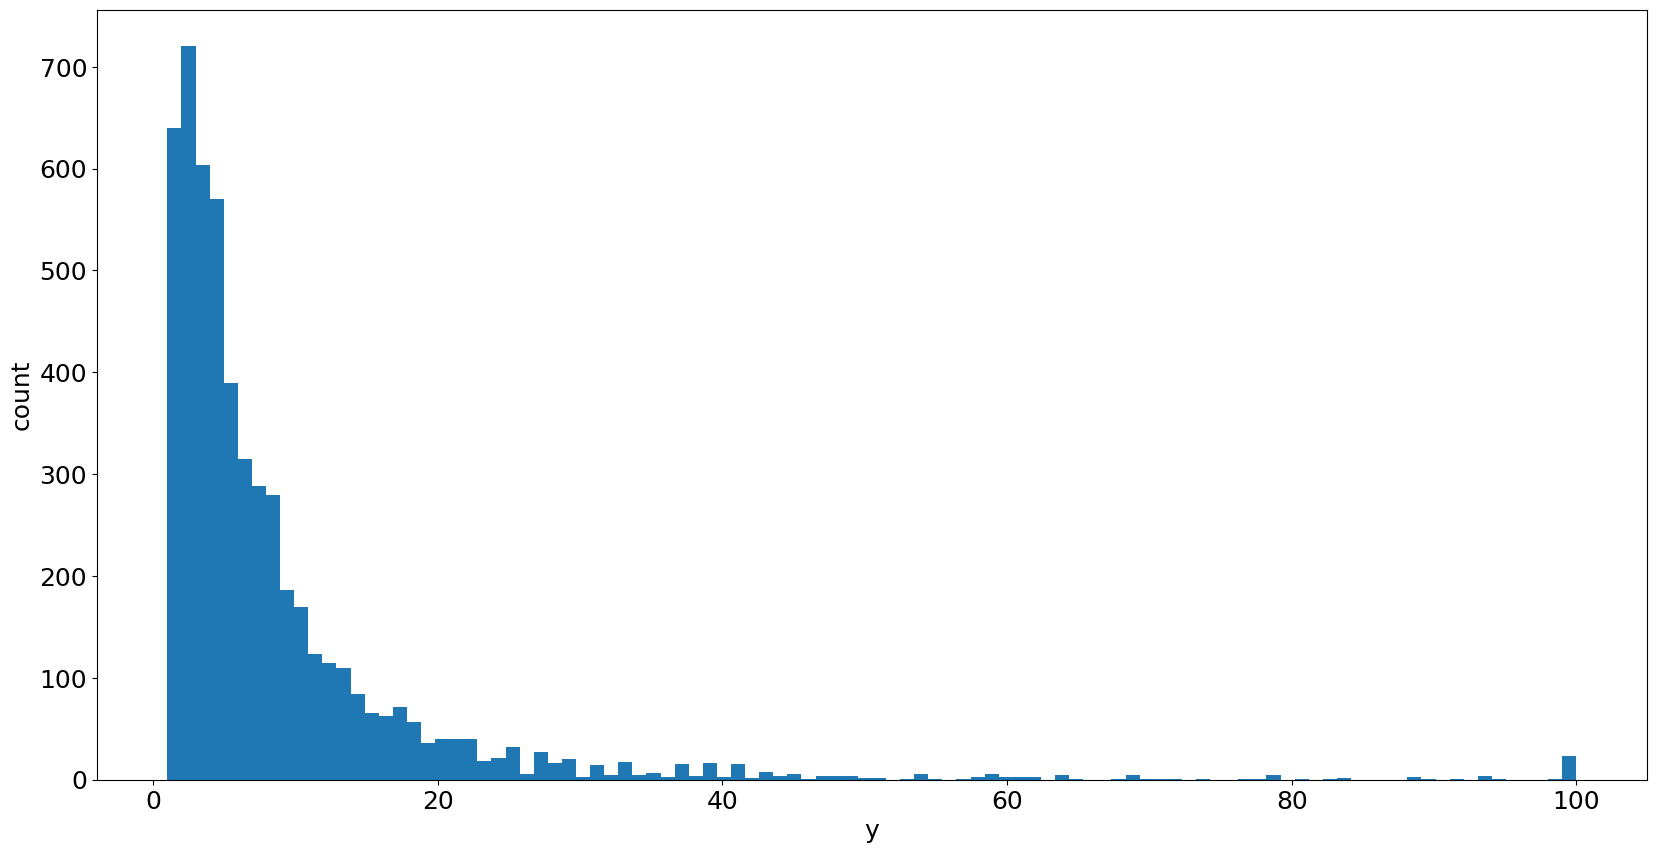

In [51]:
# bar plot of y values
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
plt.hist(y, bins=100)
plt.xlabel('y')
plt.ylabel('count')
plt.show()